# *Machine Learning* em Reanimação Neonatal
Projeto 1 da Disciplina de Aprendizado de Máquina - PPgEEC/UFRN

## Etapa 4 - TRAIN

Neste notebook será realizado o treinamento do algoritmo *Decision Tree* utilizando os artefatos criados na etapa de segregação.

## 1.  Configuração do Ambiente e Leitura de Artefatos

In [1]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Login no wandb

In [2]:
!wandb login c4d070b0b80b59891761b50eb9912749a4af585e --relogin

wandb: Appending key for api.wandb.ai to your netrc file: /Users/ericcalasans/.netrc


Variáveis globais

In [3]:
# Tamanho do conjunto de teste(fração do dataset que é utilizada como dados de teste)
val_size = 0.3

# Coeficiente de aleatoriedade
seed = 1618

# Variável alvo(target)
stratify = 'reanimacao'

# Artefato de entrada
input_artifact = 'mlreanimacao/train.csv:latest'

# Tipo do artefato
artifact_type = 'Train'

Configurações de log

In [4]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# Objeto logging
logger = logging.getLogger()

Captura de artefato

In [5]:
run = wandb.init(project='mlreanimacao', job_type='train')

# Registra um log desta ação
logger.info("Baixando artefato e realizando leitura...")
artifact = run.use_artifact(input_artifact)
artifact_file = artifact.file()
df_to_split = pd.read_csv(artifact_file)

wandb: Currently logged in as: ecalasans (use `wandb login --relogin` to force relogin)


29-05-2022 06:18:38 Baixando artefato e realizando leitura...


## 3.  Treinamento

Divisão do conjunto de treinamento

In [6]:
logger.info("Divisão em train/val")

x_train, x_val, y_train, y_val = train_test_split(df_to_split.drop(labels=stratify,axis=1),
                                                  df_to_split[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_to_split[stratify])

29-05-2022 06:19:05 Divisão em train/val


In [7]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo,apgar_1_minuto
293,30.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino,1.0
194,33.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino,9.0
182,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,n_dheg,n_dm,Masculino,6.0
46,25.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino,8.0
17,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino,3.0
243,34.0,n_fumo,n_alcool,d_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino,9.0
287,25.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino,8.0
14,24.0,n_fumo,n_alcool,n_psico,s_tpp,d_dpp,n_oligo,n_sifilis,n_hiv,s_covid,n_dheg,n_dm,Feminino,4.0


In [8]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

29-05-2022 06:19:07 x train: (267, 14)
29-05-2022 06:19:07 y train: (267,)
29-05-2022 06:19:07 x val: (115, 14)
29-05-2022 06:19:07 y val: (115,)


### 3.1. Preparação do *Dataset*

Remoção de *outliers* - só tem sentido com dados numéricos.

Será considerada a *feature* **idade_materna** como possível fonte de *outliers* e um *boxplot* da feature revelará se existe outliers a serem tratados.

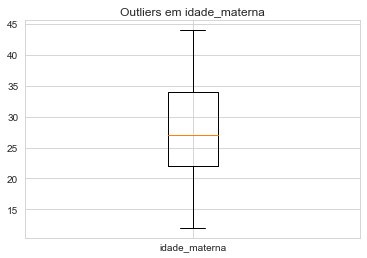

In [9]:
%matplotlib inline
plt.boxplot(df_to_split['idade_materna'])
plt.title('Outliers em idade_materna')
plt.xlabel('idade_materna')
plt.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False
)
plt.show()

A princípio não parece haver *outliers* na *feature* porém será deixada a opção de tratamento para os mesmos em caso de surgirem no *dataset*.

In [10]:
logger.info("Remoção de outliers")

# Variável temporária
x = x_train['idade_materna'].copy()

# Redimensiona variável para adequar ao procedimento - técnica sugerida pela mensagem de erro
x = x.values.reshape(-1, 1)

# Identifica e prevê outliers em um único passo
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

29-05-2022 06:19:15 Remoção de outliers


In [11]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

29-05-2022 06:19:16 x_train shape [original]: (267, 14)
29-05-2022 06:19:16 x_train shape [outlier removal]: (259, 14)


Após execução do passo anterior, percebe-se que o algoritmo considerou a existência de 12 *outliers* e os removeu, reduzindo o tamanho do *dataset*.  Desta forma o conjunto de treinamento será atualizado.

In [12]:
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [13]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo,apgar_1_minuto
293,30.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino,1.0
194,33.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino,9.0
182,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,n_dheg,n_dm,Masculino,6.0
46,25.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino,8.0
17,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,s_dm,Feminino,3.0
243,34.0,n_fumo,n_alcool,d_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Feminino,9.0
287,25.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino,8.0
14,24.0,n_fumo,n_alcool,n_psico,s_tpp,d_dpp,n_oligo,n_sifilis,n_hiv,s_covid,n_dheg,n_dm,Feminino,4.0


### 3.2.  Codificação da Variável *Target*

Neste passo a variável *target* categórica terá seus valores de texto substituídos por uma valor numérico.  Originalmente, no *dataset* recebido da API, as variáveis são já codificadas em valores numéricos pelo operador do sistema de alimentação dos dados via dicionário de dados.  No entanto, este processo foi revertido aqui na etapa de preprocessamento para fins didáticos.

In [14]:
y_train

293    sr
194    nr
182    sr
46     nr
17     nr
       ..
11     sr
243    nr
287    nr
14     sr
72     nr
Name: reanimacao, Length: 259, dtype: object

In [15]:
logger.info("Codificando variável target")
# Objeto codificador
le = LabelEncoder()

# Treinamento e transformação do conjunto de treinamento
y_train = le.fit_transform(y_train)

# Transformação do conjunto de validação - não é necessário treinamento pois já
# foi realizado
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

29-05-2022 06:19:36 Codificando variável target
29-05-2022 06:19:36 Classes [0, 1]: ['nr' 'sr']


In [16]:
y_train

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [17]:
y_val

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0])

### 3.3. Codificação das *Features*

#### 3.3.1. *Features* Categóricas

In [17]:
x_train.shape

(259, 14)

Seleciona as *features* categóricas

In [18]:
colunas = x_train.select_dtypes('object').columns.to_list()
colunas

['fumo',
 'alcool',
 'psicoativas',
 'tpp',
 'dpp',
 'oligoamnio',
 'sifilis',
 'hiv',
 'covid_mae',
 'dheg',
 'dm',
 'sexo']

In [19]:
x_val.fumo.unique()

array(['n_fumo', 'd_fumo', 's_fumo'], dtype=object)

In [20]:
for col in colunas:
    # Cria o objeto OneHotEncoder
    one_hot = OneHotEncoder(sparse=False, drop='first')

    # Treinamento do codificador
    one_hot.fit(x_train[col].values.reshape(-1,1))

    # Criação de novas colunas
    x_train[one_hot.get_feature_names_out()] = one_hot.transform(x_train[col].values.reshape(-1,1))
    x_val[one_hot.get_feature_names_out()] = one_hot.transform(x_val[col].values.reshape(-1,1))

In [21]:
x_train

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
293,30.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
194,33.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
182,39.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
46,25.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
17,26.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,34.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
243,34.0,n_fumo,n_alcool,d_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
287,25.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
14,24.0,n_fumo,n_alcool,n_psico,s_tpp,d_dpp,n_oligo,n_sifilis,n_hiv,s_covid,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [22]:
x_val

,idade_materna,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
306,35.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,d_hiv,s_covid,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
156,27.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
282,28.0,n_fumo,n_alcool,n_psico,n_tpp,s_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
281,42.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,s_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
334,40.0,n_fumo,n_alcool,n_psico,s_tpp,s_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,21.0,d_fumo,d_alcool,d_psico,n_tpp,n_dpp,d_oligo,d_sifilis,d_hiv,d_covid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
370,34.0,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,n_covid,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
18,15.0,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
172,35.0,n_fumo,n_alcool,n_psico,n_tpp,s_dpp,n_oligo,n_sifilis,n_hiv,n_covid,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [23]:
x_train.drop(columns=colunas, axis=1, inplace=True)
x_val.drop(columns=colunas, axis=1, inplace=True)

In [24]:
x_train.head()

,idade_materna,apgar_1_minuto,x0_n_fumo,x0_s_fumo,x0_n_alcool,x0_s_alcool,x0_n_psico,x0_s_psico,x0_n_tpp,x0_s_tpp,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
293,30.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
194,33.0,9.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
182,39.0,6.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
46,25.0,8.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
17,26.0,9.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [25]:
x_val.head()

,idade_materna,apgar_1_minuto,x0_n_fumo,x0_s_fumo,x0_n_alcool,x0_s_alcool,x0_n_psico,x0_s_psico,x0_n_tpp,x0_s_tpp,...,x0_s_sifilis,x0_n_hiv,x0_s_hiv,x0_n_covid,x0_s_covid,x0_n_dheg,x0_s_dheg,x0_n_dm,x0_s_dm,x0_Masculino
306,35.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
156,27.0,6.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
282,28.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
281,42.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
334,40.0,7.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [26]:
# Finaliza a execução do wandb
run.finish()

## 4. Construção do *Pipeline*

Executar parte do código acima que restaura a estrutura do artefato até antes do *OneHotEncoding*

### 4.1. Criação da Classe **FeatureSelection**

In [18]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Construtor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Override de fit
    def fit(self, X, y=None):
        return self

    # Retorna as colunas passadas no construtor
    def transform(self, X, y=None):
        return X[self.feature_names]

In [19]:
# Teste da classe
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
293,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
194,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino
182,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,n_dheg,n_dm,Masculino
46,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino
17,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino


### 4.2. Criação da Classe **CategoricalTransformer**

In [20]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Construtor
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Override de fit
    def fit(self, X, y=None):
        return self

    # Override de get_feature_names_out
    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove eventuais espaços em branco dos valores - a princípio isso não existe na base de dados
        df = df.apply(lambda row: row.str.strip())
        
        # Opção de fazer preprocessamento se new_features for True(padrão da classe)
        if self.new_features:
            df['fumo'].fillna(2, inplace=True)
            df['alcool'].fillna(2, inplace=True)
            df['psicoativas'].fillna(2, inplace=True)
            df['tpp'].fillna(2, inplace=True)
            df['dheg'].fillna(2, inplace=True)
            df['dm'].fillna(2, inplace=True)
            df['sexo'].fillna(3, inplace=True)
            df['oligoamnio'].fillna(2, inplace=True)
            df['dpp'].fillna(2, inplace=True)
            df['sifilis'].fillna(2, inplace=True)
            df['hiv'].fillna(2, inplace=True)
            df['covid_mae'].fillna(2, inplace=True)

            # Elimina valores com sexo indefinido
            df.drop(df[df['sexo'] == 3].index, inplace=True)
            
            # Categoriza as features pois o artefato retorna sempre valores numéricos
            df['fumo'].replace([0, 1, 2, 3], ['n_fumo', 's_fumo', 'n_fumo', 'd_fumo'], inplace=True)
            df['alcool'].replace([0, 1, 2, 3], ['n_alcool', 's_alcool', 'n_alcool', 'd_alcool'], inplace=True)
            df['psicoativas'].replace([0, 1, 2, 3], ['n_psico', 's_psico', 'n_psico', 'd_psico'], inplace=True)
            df['tpp'].replace([0, 1, 2, 3], ['n_tpp', 's_tpp', 'n_tpp', 'd_tpp'], inplace=True)
            df['dheg'].replace([0, 1, 2, 3], ['n_dheg', 's_dheg', 'n_dheg', 'd_dheg'], inplace=True)
            
                # Melhor adequação da feature sexo
            df['sexo'].replace([1,2], ['Feminino', 'Masculino'], inplace=True)
            df['dpp'].replace([0, 1, 2, 3], ['n_dpp', 's_dpp', 'n_dpp', 'd_dpp'], inplace=True)
            df['oligoamnio'].replace([0, 1, 2, 3], ['n_oligo', 's_oligo', 'n_oligo', 'd_oligo'], inplace=True)
            df['sifilis'].replace([0, 1, 2, 3], ['n_sifilis', 's_sifilis', 'n_sifilis', 'd_sifilis'], inplace=True)
            df['hiv'].replace([0, 1, 2, 3], ['n_hiv', 's_hiv', 'n_hiv', 'd_hiv'], inplace=True)
            df['covid_mae'].replace([0, 1, 2, 3], ['n_covid', 's_covid', 'n_covid', 'd_covid'], inplace=True)
            
                # Consolidações
            df['dm'].replace([0,1,2,3,4,5,6], ['n_dm', 'n_dm','s_dm','s_dm', 's_dm','s_dm','d_dm'], inplace=True)

        self.colnames = df.columns

        return df

In [21]:
# Validação
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
293,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
194,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino
182,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,n_dheg,n_dm,Masculino
46,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino
17,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino


In [22]:
ct = CategoricalTransformer(new_features=True, colnames=df.columns.to_list())
df_cat = ct.fit_transform(x_train)
df_cat.head()

,fumo,alcool,psicoativas,tpp,dpp,oligoamnio,sifilis,hiv,covid_mae,dheg,dm,sexo
293,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,n_dm,Masculino
194,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino
182,n_fumo,n_alcool,n_psico,n_tpp,n_dpp,n_oligo,s_sifilis,n_hiv,s_covid,n_dheg,n_dm,Masculino
46,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,n_dheg,s_dm,Masculino
17,n_fumo,n_alcool,n_psico,s_tpp,n_dpp,n_oligo,n_sifilis,n_hiv,n_covid,s_dheg,n_dm,Masculino


In [23]:
x_train.select_dtypes("object").apply(pd.Series.nunique)

fumo           3
alcool         3
psicoativas    3
tpp            3
dpp            3
oligoamnio     3
sifilis        3
hiv            3
covid_mae      3
dheg           3
dm             3
sexo           2
dtype: int64

In [24]:
df_cat.apply(pd.Series.nunique)

fumo           3
alcool         3
psicoativas    3
tpp            3
dpp            3
oligoamnio     3
sifilis        3
hiv            3
covid_mae      3
dheg           3
dm             3
sexo           2
dtype: int64

### 4.3. Criação da Classe **NumericalTransformer**

In [25]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Tipos de scalers
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    def get_feature_names_out(self):
        return self.colnames

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df


In [26]:
# Validação
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,idade_materna,apgar_1_minuto
293,30.0,1.0
194,33.0,9.0
182,39.0,6.0
46,25.0,8.0
17,26.0,9.0


In [27]:
nt = NumericalTransformer(model=1, colnames=df.columns.to_list())
df_nt = nt.fit_transform(df)
df_nt

array([[ 0.32208602, -2.45073571],
       [ 0.76424298,  1.13031111],
       [ 1.6485569 , -0.21258145],
       [-0.41484224,  0.68268026],
       [-0.26745659,  1.13031111],
       [ 0.61685733,  0.68268026],
       [-0.41484224, -0.6602123 ],
       [ 0.76424298,  0.68268026],
       [-0.12007094, -2.45073571],
       [ 0.91162864,  0.68268026],
       [ 0.46947168, -0.21258145],
       [-0.12007094, -0.6602123 ],
       [ 0.76424298, -1.555474  ],
       [-0.70961355, -0.21258145],
       [-1.44654182,  0.68268026],
       [-1.00438486,  0.68268026],
       [-1.00438486,  0.2350494 ],
       [-1.29915617, -2.45073571],
       [-0.70961355,  0.68268026],
       [ 0.46947168,  0.68268026],
       [-0.5622279 ,  0.68268026],
       [-0.12007094, -1.10784315],
       [-0.5622279 ,  0.2350494 ],
       [-0.85699921,  1.13031111],
       [-0.85699921, -1.10784315],
       [ 1.05901429, -1.555474  ],
       [ 1.05901429,  0.68268026],
       [ 1.05901429,  1.13031111],
       [ 0.76424298,

In [28]:
nt.get_feature_names_out()

['idade_materna', 'apgar_1_minuto']

### 4.4.  Encadeamento

In [29]:
# Tipos de scalers = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Features categóricas
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Features numéricas
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# A parte de preenchimento de dados faltantes já é realizada pela classe CategoricalTransformer
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="first"))
                                       ]
                                )

# A parte de preenchimento de dados faltantes já é realizada pela classe NumericalTransformer
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('num_transformer', NumericalTransformer(numerical_model,
                                                                              colnames=numerical_features))])

# Reune os Pipelines num só
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)])

In [30]:
# Validação
new_data = full_pipeline_preprocessing.fit_transform(x_train)

In [31]:
new_data

array([[1.        , 0.        , 1.        , ..., 1.        , 0.53846154,
        0.11111111],
       [1.        , 0.        , 1.        , ..., 1.        , 0.65384615,
        1.        ],
       [1.        , 0.        , 1.        , ..., 1.        , 0.88461538,
        0.66666667],
       ...,
       [1.        , 0.        , 1.        , ..., 1.        , 0.34615385,
        0.88888889],
       [1.        , 0.        , 1.        , ..., 0.        , 0.30769231,
        0.44444444],
       [1.        , 0.        , 1.        , ..., 0.        , 0.30769231,
        0.88888889]])

In [32]:
cat_names = list(full_pipeline_preprocessing.get_params()['cat_pipeline'][2].get_feature_names_out())
cat_names

['fumo_n_fumo',
 'fumo_s_fumo',
 'alcool_n_alcool',
 'alcool_s_alcool',
 'psicoativas_n_psico',
 'psicoativas_s_psico',
 'tpp_n_tpp',
 'tpp_s_tpp',
 'dpp_n_dpp',
 'dpp_s_dpp',
 'oligoamnio_n_oligo',
 'oligoamnio_s_oligo',
 'sifilis_n_sifilis',
 'sifilis_s_sifilis',
 'hiv_n_hiv',
 'hiv_s_hiv',
 'covid_mae_n_covid',
 'covid_mae_s_covid',
 'dheg_n_dheg',
 'dheg_s_dheg',
 'dm_n_dm',
 'dm_s_dm',
 'sexo_Masculino']

In [33]:
num_names = full_pipeline_preprocessing.get_params()['num_pipeline'][1].get_feature_names_out()
type(num_names)

list

In [34]:
df = pd.DataFrame(new_data, columns=cat_names+num_names)
df.head()

,fumo_n_fumo,fumo_s_fumo,alcool_n_alcool,alcool_s_alcool,psicoativas_n_psico,psicoativas_s_psico,tpp_n_tpp,tpp_s_tpp,dpp_n_dpp,dpp_s_dpp,...,hiv_s_hiv,covid_mae_n_covid,covid_mae_s_covid,dheg_n_dheg,dheg_s_dheg,dm_n_dm,dm_s_dm,sexo_Masculino,idade_materna,apgar_1_minuto
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.538462,0.111111
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.653846,1.000000
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.884615,0.666667
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.346154,0.888889
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.384615,1.000000


## 5. *Holdout Training*

Pipeline completo e treinamento

In [50]:
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# training
logger.info("Treinando...")
pipe.fit(x_train, y_train)

# predict
logger.info("Inferindo valores...")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Métricas de avaliação")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

29-05-2022 05:58:48 Treinando...
29-05-2022 05:58:48 Inferindo valores...
29-05-2022 05:58:48 Métricas de avaliação
29-05-2022 05:58:48 Accuracy: 0.7391304347826086
29-05-2022 05:58:48 Precision: 0.6545454545454545
29-05-2022 05:58:48 Recall: 0.7659574468085106
29-05-2022 05:58:48 F1: 0.7058823529411765


Upload de informações para o *wandb*

In [32]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

Avalia possíveis vieses no modelo

In [33]:
# predict bias
logger.info("Inferindo viés...")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Métricas de avaliação de viés")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

29-05-2022 05:13:32 Inferindo viés...
29-05-2022 05:13:32 Métricas de avaliação de viés
29-05-2022 05:13:32 Bias Accuracy: 0.9884169884169884
29-05-2022 05:13:32 Bias Precision: 1.0
29-05-2022 05:13:32 Bias Recall: 0.9716981132075472
29-05-2022 05:13:32 Bias F1: 0.985645933014354


Observa-se que, mesmo para os dados de treinamento, ainda há um certo grau de erro em reconhecer quem precisa de reanimação ou não porém, considerando um IC de 95%, pode-se dizer que o modelo é aceitável.

Comparação de métricas

In [34]:
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77        68
           1       0.65      0.77      0.71        47

    accuracy                           0.74       115
   macro avg       0.74      0.74      0.74       115
weighted avg       0.75      0.74      0.74       115



Matriz de confusão

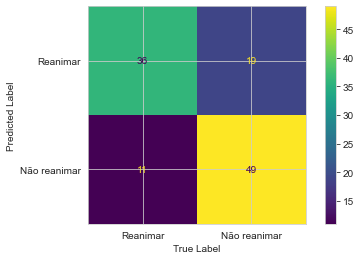

In [35]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["Reanimar","Não reanimar"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [36]:
df = pd.DataFrame(y_val, columns=['TrueValue'])

In [37]:
df[df['TrueValue'] == 1].count()

TrueValue    47
dtype: int64

Gráficos do treinamento

In [41]:
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][2].get_feature_names_out().tolist()
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][1].get_feature_names_out()
all_names = cat_names + num_names
all_names

['fumo_n_fumo',
 'fumo_s_fumo',
 'alcool_n_alcool',
 'alcool_s_alcool',
 'psicoativas_n_psico',
 'psicoativas_s_psico',
 'tpp_n_tpp',
 'tpp_s_tpp',
 'dpp_n_dpp',
 'dpp_s_dpp',
 'oligoamnio_n_oligo',
 'oligoamnio_s_oligo',
 'sifilis_n_sifilis',
 'sifilis_s_sifilis',
 'hiv_n_hiv',
 'hiv_s_hiv',
 'covid_mae_n_covid',
 'covid_mae_s_covid',
 'dheg_n_dheg',
 'dheg_s_dheg',
 'dm_n_dm',
 'dm_s_dm',
 'sexo_Masculino',
 'idade_materna',
 'apgar_1_minuto']

In [42]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [43]:
run.finish()

Acc,0.73913
F1,0.70588
Precision,0.65455
Recall,0.76596


## 6.  Ajuste de Hiperparâmetros

Aqui será explorada a seção **Sweep** do wandb, que disponibiliza vários métodos para o ajuste de hiperparâmetros do modelo.

In [44]:
seed = 1618

Configurações do **Sweep*

In [45]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
        },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="mlreanimacao")

Create sweep with ID: sv2on0ss
Sweep URL: https://wandb.ai/ecalasans/mlreanimacao/sweeps/sv2on0ss


Define uma função para ser passada para o **Sweep**

In [46]:
#pipe.named_steps['full_pipeline'].get_params()

{'n_jobs': None,
 'transformer_list': [('cat_pipeline',
   Pipeline(steps=[('cat_selector',
                    FeatureSelector(feature_names=['fumo', 'alcool', 'psicoativas',
                                                   'tpp', 'dpp', 'oligoamnio',
                                                   'sifilis', 'hiv', 'covid_mae',
                                                   'dheg', 'dm', 'sexo'])),
                   ('cat_transformer',
                    CategoricalTransformer(colnames=Index(['fumo', 'alcool', 'psicoativas', 'tpp', 'dpp', 'oligoamnio', 'sifilis',
          'hiv', 'covid_mae', 'dheg', 'dm', 'sexo'],
         dtype='object'))),
                   ('cat_encoder', OneHotEncoder(drop='first', sparse=False))])),
  ('num_pipeline',
   Pipeline(steps=[('num_selector',
                    FeatureSelector(feature_names=['idade_materna',
                                                   'apgar_1_minuto'])),
                   ('num_transformer',
                    

In [47]:
def train():
    with wandb.init() as run:

        # The full pipeline
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                 ("classifier",DecisionTreeClassifier())
                                 ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [48]:
wandb.agent(sweep_id=sweep_id, function=train, count=6)

wandb: Agent Starting Run: bmse7s2c with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 1618
wandb: 	splitter: random


29-05-2022 05:42:09 Training
29-05-2022 05:42:09 Infering
29-05-2022 05:42:09 Evaluation metrics
29-05-2022 05:42:09 Accuracy: 0.7391304347826086
29-05-2022 05:42:09 Precision: 0.6545454545454545
29-05-2022 05:42:09 Recall: 0.7659574468085106
29-05-2022 05:42:09 F1: 0.7058823529411765


Accuracy,0.73913
F1,0.70588
Precision,0.65455
Recall,0.76596


wandb: Agent Starting Run: jn5re678 with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 1618
wandb: 	splitter: random


29-05-2022 05:42:32 Training
29-05-2022 05:42:32 Infering
29-05-2022 05:42:32 Evaluation metrics
29-05-2022 05:42:32 Accuracy: 0.8
29-05-2022 05:42:32 Precision: 0.75
29-05-2022 05:42:32 Recall: 0.7659574468085106
29-05-2022 05:42:32 F1: 0.7578947368421053


Accuracy,0.8
F1,0.75789
Precision,0.75
Recall,0.76596


wandb: Agent Starting Run: gq0n1n95 with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 1618
wandb: 	splitter: random


29-05-2022 05:42:59 Training
29-05-2022 05:43:00 Infering
29-05-2022 05:43:00 Evaluation metrics
29-05-2022 05:43:00 Accuracy: 0.7391304347826086
29-05-2022 05:43:00 Precision: 0.6545454545454545
29-05-2022 05:43:00 Recall: 0.7659574468085106
29-05-2022 05:43:00 F1: 0.7058823529411765


Accuracy,0.73913
F1,0.70588
Precision,0.65455
Recall,0.76596


wandb: Agent Starting Run: 636rx3rj with config:
wandb: 	criterion: entropy
wandb: 	model: 0
wandb: 	random_state: 1618
wandb: 	splitter: random


29-05-2022 05:43:25 Training
29-05-2022 05:43:26 Infering
29-05-2022 05:43:26 Evaluation metrics
29-05-2022 05:43:26 Accuracy: 0.7391304347826086
29-05-2022 05:43:26 Precision: 0.6545454545454545
29-05-2022 05:43:26 Recall: 0.7659574468085106
29-05-2022 05:43:26 F1: 0.7058823529411765


Accuracy,0.73913
F1,0.70588
Precision,0.65455
Recall,0.76596


wandb: Agent Starting Run: 15t9lnqi with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 1618
wandb: 	splitter: random


29-05-2022 05:43:53 Training
29-05-2022 05:43:53 Infering
29-05-2022 05:43:53 Evaluation metrics
29-05-2022 05:43:53 Accuracy: 0.8
29-05-2022 05:43:53 Precision: 0.75
29-05-2022 05:43:53 Recall: 0.7659574468085106
29-05-2022 05:43:53 F1: 0.7578947368421053


Accuracy,0.8
F1,0.75789
Precision,0.75
Recall,0.76596


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8x5g2ua with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 1618
wandb: 	splitter: best


29-05-2022 05:44:23 Training
29-05-2022 05:44:23 Infering
29-05-2022 05:44:24 Evaluation metrics
29-05-2022 05:44:24 Accuracy: 0.7304347826086957
29-05-2022 05:44:24 Precision: 0.6481481481481481
29-05-2022 05:44:24 Recall: 0.7446808510638298
29-05-2022 05:44:24 F1: 0.6930693069306931


Accuracy,0.73043
F1,0.69307
Precision,0.64815
Recall,0.74468


## 7.  Configuração, Treinamento e Exportação do Melhor Modelo

### 7.1. Configuração

Realizado a avaliação do treinamento, nesta etapa será realizado um novo treinamento do modelo, desta vez com os resultados de configuração obtidos na etapa anterior.  Revisando os dados obtidos tem-se:

In [51]:
logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

29-05-2022 05:59:01 Accuracy: 0.7391304347826086
29-05-2022 05:59:01 Precision: 0.6545454545454545
29-05-2022 05:59:01 Recall: 0.7659574468085106
29-05-2022 05:59:01 F1: 0.7058823529411765


Em consulta ao **Sweep** do wandb, duas execuções demonstraram-se mais eficientes em melhorar os índices de acurácia, F1 e *precision*, mantendo o *recall* praticamente inalterado.  Selecionou-se a **heart-sweep-5** por apresentar tempo de execução ligeiramente menor(1s menor que sua concorrente que apresenta os mesmos resultados e as mesmas configurações).

Devido a uma característica da interação entre o wandb e o jupyter se faz necessário o reinício do ambiente para que se desvincule a última execução do wandb realizada na fase de ajuste de hiperparâmetros.  Dessa forma, também se faz necessária a execução de todos os itens deste notebook exceto o **5** e **6**.  Após realizado isto, executa-se o wandb novamente selecionando o projeto e o tipo de trabalho(*job type*).

In [35]:
run = wandb.init(project='mlreanimacao', job_type='train')

### 7.2. Treinamento

Executa-se agora o *pipeline* com os ajustes apontados pela melhor execução no wandb.

In [36]:
# The full pipeline
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 0})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__random_state": 1618})

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

29-05-2022 06:34:09 Training
29-05-2022 06:34:09 Infering
29-05-2022 06:34:09 Evaluation metrics
29-05-2022 06:34:09 Accuracy: 0.8
29-05-2022 06:34:09 Precision: 0.75
29-05-2022 06:34:09 Recall: 0.7659574468085106
29-05-2022 06:34:09 F1: 0.7578947368421053


Geração de gráficos com o modelo otimizado para o wandb

In [37]:
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][2].get_feature_names_out().tolist()
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][1].get_feature_names_out()
all_names = cat_names + num_names
all_names

['fumo_n_fumo',
 'fumo_s_fumo',
 'alcool_n_alcool',
 'alcool_s_alcool',
 'psicoativas_n_psico',
 'psicoativas_s_psico',
 'tpp_n_tpp',
 'tpp_s_tpp',
 'dpp_n_dpp',
 'dpp_s_dpp',
 'oligoamnio_n_oligo',
 'oligoamnio_s_oligo',
 'sifilis_n_sifilis',
 'sifilis_s_sifilis',
 'hiv_n_hiv',
 'hiv_s_hiv',
 'covid_mae_n_covid',
 'covid_mae_s_covid',
 'dheg_n_dheg',
 'dheg_s_dheg',
 'dm_n_dm',
 'dm_s_dm',
 'sexo_Masculino',
 'idade_materna',
 'apgar_1_minuto']

In [38]:
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


### 7.3. Exportação do Modelo

Variáveis auxiliares

In [39]:
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

Uso do módulo **joblib** para auxiliar na tarefa de exportação realizando a serialização dos objetos **pipe** e **le**.

In [40]:
logger.info("Salvando artefatos na máquina...")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

29-05-2022 06:42:13 Salvando artefatos na máquina...


['target_encoder']

Geração do artefato do modelo

In [41]:
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="Pipeline completo de Preprocessamento e Treinamento do Modelo"
                          )

logger.info("Gerando artefato do modelo...")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

29-05-2022 06:44:44 Gerando artefato do modelo


Geração do artefato do codificador da *target*

In [42]:
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="Codificador da target"
                          )

logger.info("Gerando artefato do codificador...")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

29-05-2022 06:45:34 Gerando artefato do codificador...


In [43]:
# Finaliza execução no wandb
run.finish()

Accuracy,0.8
F1,0.75789
Precision,0.75
Recall,0.76596
